# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## Authors
Write the name (first and last) of the people on your team that are responsible for developing this solution.

Joao Louro ( Team Captain )

Bharathi A

Shubham Jangir

## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

World Weather Online Data for historical weather data

Due to some issues with colab, folium maps aren't displayed. Therefore, we have added screenshots of the plots. They are not interactive

## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

We have 5 sensors in San Salvario, Italy. For which we want to analyse and predict noise levels in night.
We have noise levels (in decibels) for each of the sensors, for each day and hour (0 to 23)

We also have Wifi data (number of visitors) for a day and hour levels
We also have telecommunications data, telling us the number of active simcard counts for a particular day and hour

We have also take weather data (temperature) for each day and hour into consideration
And finally, we also have number of police complaints in the area, for each day.

## Development


# **Import Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install geopandas wwo-hist folium --upgrade -q

In [ ]:
!pip install urllib3

In [ ]:
import pandas as pd
import requests, zipfile, io
import geopandas as gpd
from folium.features import DivIcon
import branca.colormap as cm
import os
from datetime import timedelta
from wwo_hist import retrieve_hist_data
import folium
import urllib3
from zipfile import ZipFile
import statsmodels.api as sm
import matplotlib.pyplot as plt
import urllib.request

import warnings
warnings.simplefilter(action='ignore')

In [ ]:
def show_image(url):
  f = urllib.request.urlopen(url)

  # read the image file in a numpy array
  a = plt.imread(f)
  plt.figure(figsize=(15,15))
  plt.imshow(a)
  plt.show()

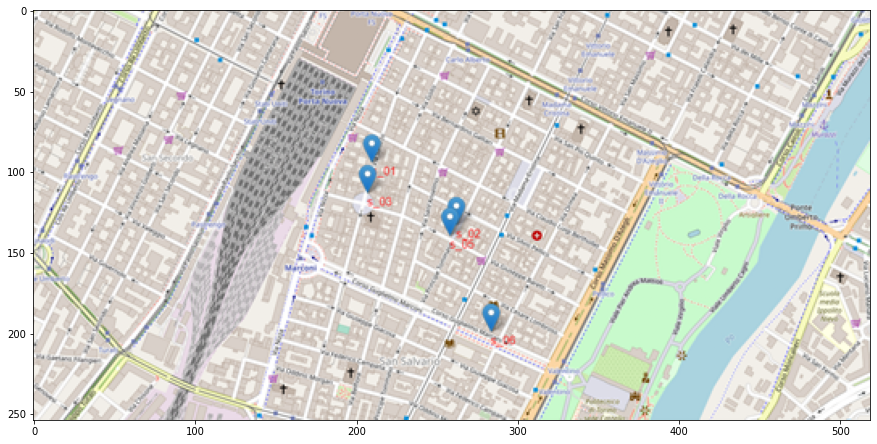

In [ ]:
show_image('https://raw.githubusercontent.com/Bharathi-A-7/WDL/main/i1.png')

# **Load Data**

In [ ]:
noise_sensor_csv = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/torino/noise_sensor_list.csv', sep=';')

In [ ]:
san_salvario_business = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/torino/businesses.csv', sep=';')

In [ ]:
os.chdir('/content/drive/MyDrive/WDL Finals')

# Sensor Data

In [ ]:
os.listdir('noise_data')

['TTO-001_5minute.csv',
 'san_salvario_2017.csv',
 'TTO-002_5minute.csv',
 'san_salvario_2016.csv',
 'TTO-002_hourly.csv',
 'san_salvario_2021.csv',
 'san_salvario_2020.csv',
 'TTO-001_hourly.csv',
 'san_salvario_2018.csv',
 'san_salvario_2019.csv']

In [ ]:
# We import data for each year, and then we combine them
san_salvario_2016 = pd.read_csv('noise_data/san_salvario_2016.csv', skiprows=8, sep=';')
san_salvario_2017 = pd.read_csv('noise_data/san_salvario_2017.csv', skiprows=8, sep=';')
san_salvario_2018 = pd.read_csv('noise_data/san_salvario_2018.csv', skiprows=8, sep=';')
san_salvario_2019 = pd.read_csv('noise_data/san_salvario_2019.csv', skiprows=8, sep=';')
san_salvario_2020 = pd.read_csv('noise_data/san_salvario_2020.csv', skiprows=8, sep=';')
san_salvario_2021 = pd.read_csv('noise_data/san_salvario_2021.csv', skiprows=8, sep=';')

In [ ]:
san_salvario = pd.concat([san_salvario_2016, san_salvario_2017, san_salvario_2018, san_salvario_2019, san_salvario_2020, san_salvario_2021], axis=0, ignore_index=True)
print(len(san_salvario))
san_salvario.head()

44352


Data    Ora    C1    C2    C3    C4    C5
0  01-06-2016  00:00  61,1  58,8  63,7  60,4  60,2
1  01-06-2016  01:00  57,2  56,1  60,4  57,7  58,4
2  01-06-2016  02:00  52,5  53,4  52,9  56,7  56,5
3  01-06-2016  03:00  50,6  46,6  45,7  47,9  55,6
4  01-06-2016  04:00  47,4  46,2  45,1  45,8  56,8

In [ ]:
san_salvario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44352 entries, 0 to 44351
Data columns (total 7 columns):
Data    44352 non-null object
Ora     44352 non-null object
C1      40958 non-null object
C2      41623 non-null object
C3      30934 non-null object
C4      24793 non-null object
C5      27494 non-null object
dtypes: object(7)
memory usage: 2.4+ MB


In [ ]:
san_salvario.nunique()

Data    1848
Ora       24
C1       449
C2       414
C3       470
C4       350
C5       351
dtype: int64

In [ ]:
# Noise data - TTO

In [ ]:
tto_data_h1 = pd.read_csv('noise_data/TTO-001_hourly.csv')
tto_data_h2 = pd.read_csv('noise_data/TTO-002_hourly.csv')
tto_data_h = tto_data_h1.append(tto_data_h2)
print(len(tto_data_h))
tto_data_h.head()

21067


date (UTC) time (UTC)  ...  filtered mean  filtered number of points
0  23-11-2018   00:00:00  ...            NaN                          0
1  23-11-2018   01:00:00  ...            NaN                          0
2  23-11-2018   02:00:00  ...            NaN                          0
3  23-11-2018   03:00:00  ...            NaN                          0
4  23-11-2018   04:00:00  ...            NaN                          0

[5 rows x 6 columns]

In [ ]:
tto_data_h = tto_data_h.rename(columns = {'mean':'tto_mean'})

In [ ]:
tto_data_h.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21067 entries, 0 to 6066
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date (UTC)                 21067 non-null  object 
 1   time (UTC)                 21067 non-null  object 
 2   tto_mean                   21067 non-null  float64
 3   number of points           21067 non-null  int64  
 4   filtered mean              0 non-null      float64
 5   filtered number of points  21067 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 1.1+ MB


In [ ]:
tto_data_h.nunique()

date (UTC)                   884
time (UTC)                    24
tto_mean                     254
number of points              53
filtered mean                  0
filtered number of points      1
dtype: int64

We drop columns that have only 1 value or very less unique information

In [ ]:
tto_data_h = tto_data_h.drop(['number of points','filtered mean', 'filtered number of points'], axis=1)
#tto_data_h.describe(include='all')

In [ ]:
# Make combined datetime column and then convert into date and hour
tto_data_h['datetime'] = tto_data_h['date (UTC)'] +' ' + tto_data_h['time (UTC)']
tto_data_h['datetime'] = pd.to_datetime(tto_data_h['datetime'])
tto_data_h['datetime_tz'] = tto_data_h['datetime'] - timedelta(hours=6)

tto_data_h['Date'] = pd.to_datetime(tto_data_h['datetime_tz'].dt.date)
tto_data_h['Hour'] = tto_data_h['datetime_tz'].dt.hour
print(len(tto_data_h))
tto_data_h.head()

21067


date (UTC) time (UTC)  tto_mean  ...         datetime_tz       Date Hour
0  23-11-2018   00:00:00      67.5  ... 2018-11-22 18:00:00 2018-11-22   18
1  23-11-2018   01:00:00      64.3  ... 2018-11-22 19:00:00 2018-11-22   19
2  23-11-2018   02:00:00      63.4  ... 2018-11-22 20:00:00 2018-11-22   20
3  23-11-2018   03:00:00      63.5  ... 2018-11-22 21:00:00 2018-11-22   21
4  23-11-2018   04:00:00      65.2  ... 2018-11-22 22:00:00 2018-11-22   22

[5 rows x 7 columns]

In [ ]:
tto_data_h = tto_data_h.drop_duplicates(subset = ['Date','Hour'])
tto_data_h = tto_data_h.sort_values(by = ['Date','Hour'])
print(len(tto_data_h))
tto_data_h.head()

21065


date (UTC) time (UTC)  tto_mean  ...         datetime_tz       Date Hour
192  01-12-2018   00:00:00      71.2  ... 2018-01-11 18:00:00 2018-01-11   18
193  01-12-2018   01:00:00      68.3  ... 2018-01-11 19:00:00 2018-01-11   19
194  01-12-2018   02:00:00      68.6  ... 2018-01-11 20:00:00 2018-01-11   20
195  01-12-2018   03:00:00      64.5  ... 2018-01-11 21:00:00 2018-01-11   21
196  01-12-2018   04:00:00      64.9  ... 2018-01-11 22:00:00 2018-01-11   22

[5 rows x 7 columns]

# Sim count data

In [ ]:
os.listdir('sim_count')

['.DS_Store',
 'SIM_count_04_100618.csv',
 'SIM_count_18_241217.csv',
 'SIM Count - 20200430 - 20200615',
 'SIM Count - 20210430 - 20210615',
 'SIM_count_15_210118.csv',
 'SIM_count_19_250318.csv',
 'SIM_count_09_151017.csv']

In [ ]:
# Listing sample files in the directory
os.listdir('sim_count/SIM Count - 20210430 - 20210615')[:5]

['fpresencedata_20210502_220000_20210503_220000.csv',
 'fpresencedata_20210506_220000_20210507_220000.csv',
 'fpresencedata_20210501_220000_20210502_220000.csv',
 'fpresencedata_20210505_220000_20210506_220000.csv',
 'fpresencedata_20210613_220000_20210614_220000.csv']

In [ ]:
sim_data_files = os.listdir('sim_count/SIM Count - 20210430 - 20210615')
len(sim_data_files)

46

In [ ]:
# Reading all same schema files and combining them
sim_data = pd.DataFrame()
for file in sim_data_files:
    sim_data = sim_data.append(pd.read_csv('sim_count/SIM Count - 20210430 - 20210615/'+file, sep=';'))
print(len(sim_data))
sim_data.head()

20976


layerid  ... datavalue
0  8597bcee-3925-4c86-a120-9f3a54781a81  ...     278.0
1  8597bcee-3925-4c86-a120-9f3a54781a81  ...    3876.0
2  8597bcee-3925-4c86-a120-9f3a54781a81  ...    3121.0
3  8597bcee-3925-4c86-a120-9f3a54781a81  ...    3764.0
4  8597bcee-3925-4c86-a120-9f3a54781a81  ...    4597.0

[5 rows x 5 columns]

In [ ]:
sim_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20976 entries, 0 to 455
Data columns (total 5 columns):
layerid      20976 non-null object
datefrom     20976 non-null object
dateto       20976 non-null object
datatype     20976 non-null object
datavalue    20976 non-null float64
dtypes: float64(1), object(4)
memory usage: 983.2+ KB


In [ ]:
# Convertime timestamp columns to datetime
for i in ['datefrom','dateto']:
    sim_data[i] = pd.to_datetime(sim_data[i])
sim_data.head()

layerid            datefrom  ... datatype datavalue
0  8597bcee-3925-4c86-a120-9f3a54781a81 2021-05-03 03:00:00  ...       F1     278.0
1  8597bcee-3925-4c86-a120-9f3a54781a81 2021-05-03 03:00:00  ...       F2    3876.0
2  8597bcee-3925-4c86-a120-9f3a54781a81 2021-05-03 03:00:00  ...       F3    3121.0
3  8597bcee-3925-4c86-a120-9f3a54781a81 2021-05-03 03:00:00  ...       F4    3764.0
4  8597bcee-3925-4c86-a120-9f3a54781a81 2021-05-03 03:00:00  ...       F5    4597.0

[5 rows x 5 columns]

In [ ]:
sim_data['hour_diff'] = (sim_data['dateto']-sim_data['datefrom']).astype('timedelta64[h]')
sim_data.describe()
# Period is 1hr typically

datavalue  hour_diff
count  20976.000000    20976.0
mean   11295.965151        1.0
std    11518.117499        0.0
min      193.000000        1.0
25%     2699.000000        1.0
50%     5635.000000        1.0
75%    19198.000000        1.0
max    37122.000000        1.0

So, "dateto" can be taken as representative date and hour for noise comparison

In [ ]:
sim_data['Date'] = pd.to_datetime(sim_data['dateto'].dt.date)
sim_data['Hour'] = sim_data['dateto'].dt.hour
print(len(sim_data))
sim_data.head()

20976


layerid            datefrom  ...       Date Hour
0  8597bcee-3925-4c86-a120-9f3a54781a81 2021-05-03 03:00:00  ... 2021-05-03    4
1  8597bcee-3925-4c86-a120-9f3a54781a81 2021-05-03 03:00:00  ... 2021-05-03    4
2  8597bcee-3925-4c86-a120-9f3a54781a81 2021-05-03 03:00:00  ... 2021-05-03    4
3  8597bcee-3925-4c86-a120-9f3a54781a81 2021-05-03 03:00:00  ... 2021-05-03    4
4  8597bcee-3925-4c86-a120-9f3a54781a81 2021-05-03 03:00:00  ... 2021-05-03    4

[5 rows x 8 columns]

We have, for each day, hour and datatype, a datavalue. So appropriate pivot is required in order to consume this data

In [ ]:
# Final dataset for sim data
sim_data_pivot = sim_data.pivot_table(index = ['Date','Hour'],
                                      columns = ['datatype'],
                                      values = 'datavalue').reset_index()
print(len(sim_data_pivot))
print(len(sim_data_pivot.columns))
sim_data_pivot.head()

1104
21


datatype       Date  Hour     F1      F2  ...      Vi      Vp       Vr     Vs
0        2021-04-30    23  286.0  4039.0  ...  4972.0  1182.0  23517.0  556.0
1        2021-05-01     0  297.0  3894.0  ...  3859.0   926.0  24478.0  553.0
2        2021-05-01     1  292.0  3767.0  ...  2930.0   800.0  25191.0  548.0
3        2021-05-01     2  285.0  3797.0  ...  2720.0   717.0  25390.0  546.0
4        2021-05-01     3  286.0  3777.0  ...  2647.0   654.0  25244.0  511.0

[5 rows x 21 columns]

# Weather

In [ ]:
os.listdir('weather')

['.DS_Store', 'weather_2.csv', 'weather_1.csv']

# The files given were difficult to interpret, so we used OpenWeather API to fetch weather data

In [ ]:
weather = pd.read_csv('Turin_weather.csv')
print(len(weather))
weather.head()

40200


Unnamed: 0        date      time  avg_tempC
0           0  2016-06-01  00:00:00       15.5
1           1  2016-06-01  01:00:00       15.5
2           2  2016-06-01  02:00:00       15.5
3           3  2016-06-01  03:00:00       15.5
4           4  2016-06-01  04:00:00       15.5

In [ ]:
# Make combined datetime column and then convert into date and hour
weather['datetime'] = weather['date'] +' ' + weather['time']
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather['Date'] = pd.to_datetime(weather['datetime'].dt.date)
weather['Hour'] = weather['datetime'].dt.hour
print(len(weather))
weather.head()

40200


Unnamed: 0        date      time  ...            datetime       Date Hour
0           0  2016-06-01  00:00:00  ... 2016-06-01 00:00:00 2016-06-01    0
1           1  2016-06-01  01:00:00  ... 2016-06-01 01:00:00 2016-06-01    1
2           2  2016-06-01  02:00:00  ... 2016-06-01 02:00:00 2016-06-01    2
3           3  2016-06-01  03:00:00  ... 2016-06-01 03:00:00 2016-06-01    3
4           4  2016-06-01  04:00:00  ... 2016-06-01 04:00:00 2016-06-01    4

[5 rows x 7 columns]

In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40200 entries, 0 to 40199
Data columns (total 7 columns):
Unnamed: 0    40200 non-null int64
date          40200 non-null object
time          40200 non-null object
avg_tempC     40200 non-null float64
datetime      40200 non-null datetime64[ns]
Date          40200 non-null datetime64[ns]
Hour          40200 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 2.1+ MB


# Wifi Data

In [ ]:
# Data is mostly from 2018

In [ ]:
san_salvario_wifi = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/torino/WIFI%20Count.csv')
print(len(san_salvario_wifi))
san_salvario_wifi.head()

1639


Time  No. of Visitors
0  2018-10-24 17:00               47
1  2018-10-24 18:00              155
2  2018-10-24 19:00              181
3  2018-10-24 20:00              211
4  2018-10-24 21:00              239

In [ ]:
san_salvario_wifi = san_salvario_wifi.rename(columns = {'No. of Visitors':'wifi_visitors'})
san_salvario_wifi.head()

Time  wifi_visitors
0  2018-10-24 17:00             47
1  2018-10-24 18:00            155
2  2018-10-24 19:00            181
3  2018-10-24 20:00            211
4  2018-10-24 21:00            239

In [ ]:
# Getting date and hour columns
san_salvario_wifi['datetime'] = pd.to_datetime(san_salvario_wifi['Time'])
san_salvario_wifi['Date'] = pd.to_datetime(san_salvario_wifi['datetime'].dt.date)
san_salvario_wifi['Hour'] = san_salvario_wifi['datetime'].dt.hour
print(len(san_salvario_wifi))
san_salvario_wifi.head()

1639


Time  wifi_visitors            datetime       Date  Hour
0  2018-10-24 17:00             47 2018-10-24 17:00:00 2018-10-24    17
1  2018-10-24 18:00            155 2018-10-24 18:00:00 2018-10-24    18
2  2018-10-24 19:00            181 2018-10-24 19:00:00 2018-10-24    19
3  2018-10-24 20:00            211 2018-10-24 20:00:00 2018-10-24    20
4  2018-10-24 21:00            239 2018-10-24 21:00:00 2018-10-24    21

In [ ]:
wifi_data = san_salvario_wifi.copy()
wifi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639 entries, 0 to 1638
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           1639 non-null   object        
 1   wifi_visitors  1639 non-null   int64         
 2   datetime       1639 non-null   datetime64[ns]
 3   Date           1639 non-null   datetime64[ns]
 4   Hour           1639 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 64.1+ KB


# Police complaints data

In [ ]:
os.listdir('police_complaints')

['OpenDataContact_Gennaio_Giugno_2016.csv',
 'OpenDataContact_Luglio_Dicembre_2017.csv',
 'Contact_Luglio_Dicembre_2016.csv',
 'OpenDataContact_Luglio_Dicembre_2018.csv',
 'OpenDataContact_Luglio_Dicembre_2019.csv',
 'Contact_Gennaio_Giugno_2017.csv',
 'OpenDataContact_Gennaio_Giugno_2019.csv',
 'OpenDataContact_Gennaio_Giugno_2018.xlsx']

In [ ]:
# Reading all files and combining them in a single data-frame
police_comp1 = pd.read_csv('police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv', encoding = 'Latin-1')
police_comp2 = pd.read_csv('police_complaints/OpenDataContact_Luglio_Dicembre_2017.csv', encoding = 'Latin-1')
police_comp3 = pd.read_csv('police_complaints/Contact_Luglio_Dicembre_2016.csv', encoding = 'Latin-1')
police_comp4 = pd.read_csv('police_complaints/OpenDataContact_Luglio_Dicembre_2018.csv', encoding = 'Latin-1')
police_comp5 = pd.read_csv('police_complaints/OpenDataContact_Luglio_Dicembre_2019.csv', sep = ';', encoding = 'Latin-1')
police_comp6 = pd.read_csv('police_complaints/Contact_Gennaio_Giugno_2017.csv', encoding = 'Latin-1')
police_comp7 = pd.read_csv('police_complaints/OpenDataContact_Gennaio_Giugno_2019.csv', encoding = 'Latin-1')
police_comp8 = pd.read_excel('police_complaints/OpenDataContact_Gennaio_Giugno_2018.xlsx')

police_comp = pd.concat([police_comp1, police_comp2, police_comp3,
                       police_comp4, police_comp5,police_comp6,
                       police_comp7,police_comp8])
print(len(police_comp))
police_comp.head()

8646


Categoria criminologa Sottocategoria Criminologica  ...        Data    Ora
0       Allarme Sociale                        Altro  ...  02/01/2016    NaN
1       Allarme Sociale                        Altro  ...  13/01/2016    NaN
2       Allarme Sociale                        Altro  ...  15/01/2016    NaN
3       Allarme Sociale                        Altro  ...  27/01/2016    NaN
4       Allarme Sociale                        Altro  ...  03/02/2016  18.45

[5 rows x 7 columns]

In [ ]:
police_comp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8646 entries, 0 to 1172
Data columns (total 7 columns):
Categoria criminologa           8646 non-null object
Sottocategoria Criminologica    8646 non-null object
Circoscrizione                  8471 non-null float64
Localita                        8471 non-null object
Area Verde                      417 non-null object
Data                            8646 non-null object
Ora                             2060 non-null float64
dtypes: float64(2), object(5)
memory usage: 540.4+ KB


In [ ]:
police_comp.nunique()

Categoria criminologa              5
Sottocategoria Criminologica      11
Circoscrizione                    10
Localita                        2369
Area Verde                         1
Data                            1312
Ora                              511
dtype: int64

In [ ]:
# Unique values of categories
police_comp[['Categoria criminologa','Sottocategoria Criminologica']].drop_duplicates()

Categoria criminologa Sottocategoria Criminologica
0          Allarme Sociale                        Altro
41         Allarme Sociale           Atti di vandalismo
48       Convivenza Civile       Aggregazioni giovanili
58       Convivenza Civile                        Altro
347      Convivenza Civile        Comportamenti molesti
381      Convivenza Civile       Disturbi altri animali
382      Convivenza Civile                Disturbi Cani
439      Convivenza Civile           Disturbi da locali
537      Convivenza Civile               Rumori molesti
611      Convivenza Civile   Uso improprio parti comuni
618       Qualitï¿½ Urbana                        Altro
796       Qualitï¿½ Urbana      Decoro e degrado urbano
1118      Qualitï¿½ Urbana          Veicoli abbandonati
570         Qualità Urbana                        Altro
761         Qualità Urbana      Decoro e degrado urbano
1053        Qualità Urbana          Veicoli abbandonati
491        QualitÃ  Urbana                        Altro
706        QualitÃ  Urbana      Decoro e degrado urbano
991        QualitÃ  Urbana          Veicoli abbandonati

In [ ]:
# Converting date to datetime type
police_comp['Date'] = pd.to_datetime(police_comp['Data'])
print(len(police_comp))
police_comp.head()

8646


Categoria criminologa Sottocategoria Criminologica  ...    Ora       Date
0       Allarme Sociale                        Altro  ...    NaN 2016-02-01
1       Allarme Sociale                        Altro  ...    NaN 2016-01-13
2       Allarme Sociale                        Altro  ...    NaN 2016-01-15
3       Allarme Sociale                        Altro  ...    NaN 2016-01-27
4       Allarme Sociale                        Altro  ...  18.45 2016-03-02

[5 rows x 8 columns]

In [ ]:
# Grouping Counting of complaints at day-level
police_comp_grp = police_comp.groupby(['Date'])['Categoria criminologa'].count().reset_index()
police_comp_grp.columns = ['Date','police_complaints']
print(len(police_comp_grp))
police_comp_grp.head()

1312


Date  police_complaints
0 2016-01-01                  2
1 2016-01-02                  6
2 2016-01-03                  6
3 2016-01-04                  4
4 2016-01-06                  6

# **Noise sensor GIS data**

In [ ]:
noise_sensor_GIS = gpd.read_file('noise_sensor_GIS/Rilievi openoise.shp')

In [ ]:
noise_sensor_GIS.head()

Id                  Sito  ... classe                  geometry
0  S_06             TOBIKE 77  ...      0  POINT (7.68255 45.05555)
1  S_05             TOBIKE 75  ...      2  POINT (7.68134 45.05759)
2  S_03             Palo Luce  ...      1  POINT (7.67886 45.05850)
3  S_02  ANCOSConfartigianato  ...      3  POINT (7.68157 45.05782)
4  S_01    Polizia Municipale  ...      2  POINT (7.67905 45.05925)

[5 rows x 7 columns]

# **Census Data**

In [ ]:
torino_census = gpd.read_file('census_data/Torino_ACE81_3003.shp')

In [ ]:
torino_census.head()

COD_REG  ...                                           geometry
0      1.0  ...  POLYGON ((1397684.098 4990958.745, 1397676.338...
1      1.0  ...  POLYGON ((1396544.848 4990399.869, 1396674.057...
2      1.0  ...  POLYGON ((1397381.695 4990677.529, 1397368.147...
3      1.0  ...  POLYGON ((1396824.866 4989610.669, 1396722.418...
4      1.0  ...  POLYGON ((1396298.448 4990620.419, 1396306.367...

[5 rows x 25 columns]

In [ ]:
sezioni_censimento = gpd.read_file('census_data/sezioni_censimento_geo_CAP.shp')

# **Exploratory Analysis**

In [ ]:
sezioni_censimento.head()
#SEZCENS = SECTION CENS
#LOCALITA = LOCATION
# PARROCCH = PARISH
#AN_0_14 = age grp

SEZCENS  NCIRCO  ...    SUPERF                                           geometry
0    326.0     8.0  ...   5593.24  POLYGON ((1396082.920 4990558.645, 1396116.595...
1    328.0     8.0  ...   8403.30  POLYGON ((1396230.062 4990481.191, 1396261.287...
2    336.0     8.0  ...   9976.84  POLYGON ((1396319.969 4990427.448, 1396404.856...
3    338.0     8.0  ...  15116.92  POLYGON ((1396509.732 4990327.177, 1396638.065...
4    343.0     8.0  ...   6922.80  POLYGON ((1396272.570 4990334.580, 1396356.838...

[5 rows x 19 columns]

In [ ]:
sezioni_censimento.reset_index(0, inplace=True)

In [ ]:
sezioni_censimento = sezioni_censimento.to_crs(epsg=4326)

In [ ]:
noise_sensor_csv.head()

code  ...                                          streaming
0  s_01  ...  https://userportal.smartdatanet.it/userportal/...
1  s_02  ...  https://userportal.smartdatanet.it/userportal/...
2  s_03  ...  https://userportal.smartdatanet.it/userportal/...
3  s_05  ...  https://userportal.smartdatanet.it/userportal/...
4  s_06  ...  https://userportal.smartdatanet.it/userportal/...

[5 rows x 5 columns]

In [ ]:
noise_sensor_csv['Lat'] = noise_sensor_csv['Lat'].str.replace(',','.').astype(float)
noise_sensor_csv['Long'] = noise_sensor_csv['Long'].str.replace(',','.').astype(float)

In [ ]:
noise_sensor_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   code       5 non-null      object 
 1   address    5 non-null      object 
 2   Lat        5 non-null      float64
 3   Long       5 non-null      float64
 4   streaming  5 non-null      object 
dtypes: float64(2), object(3)
memory usage: 328.0+ bytes


In [ ]:
sensor_coords = list(zip(noise_sensor_csv['Lat'], noise_sensor_csv['Long'], noise_sensor_csv['code']))


m1 = folium.Map(location=[45.055655,7.678555], zoom_start=15)

for coord in sensor_coords:

  folium.Marker( location=[ coord[0], coord[1]], fill_color = '#43d9de', radius=8).add_to(m1)

  folium.Marker( location=[ coord[0], coord[1]], fill_color = '#43d9de', radius=8, icon=DivIcon(icon_size=(100,50), icon_anchor=(0,0),
        html='<div style="font-size: 12pt; color: %s ">%s</div>' % ('red',coord[2]))).add_to(m1)

m1

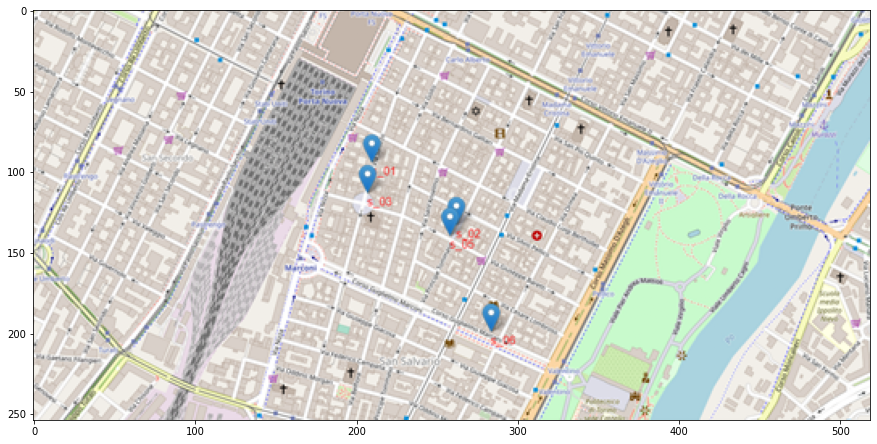

In [ ]:
show_image('https://raw.githubusercontent.com/Bharathi-A-7/WDL/main/i1.png')

The above map shows us the location and distribution of sensors within the San Salvario city. Since the sensors are close to a river/stream, where most people gather and have many businesses around, the noise levels in this area is supposed to be high, so the sensors are placed at the right locations.

In [ ]:
sezioni_geometry = sezioni_censimento[['index','geometry']]

In [ ]:
sezioni_censimento['pop_density'] = sezioni_censimento['NRESID']/sezioni_censimento['SUPERF']
sezioni_censimento['s5_density'] = sezioni_censimento['OLT_65_A']/sezioni_censimento['SUPERF']

In [ ]:
sezioni_superf = sezioni_geometry.merge(sezioni_censimento[['index','SUPERF','SEZCENS']], on='index')
sezioni_population = sezioni_geometry.merge(sezioni_censimento[['index','SEZCENS','NRESID']])
sezioni_families = sezioni_geometry.merge(sezioni_censimento[['index','SEZCENS','NFAMIGL']])
sezioni_65plus = sezioni_geometry.merge(sezioni_censimento[['index','SEZCENS','OLT_65_A']])
sezioni_foreigners = sezioni_geometry.merge(sezioni_censimento[['index','SEZCENS','NSTRAN']])
sezioni_popdens = sezioni_geometry.merge(sezioni_censimento[['index','SEZCENS','pop_density']])
sezioni_sdens = sezioni_geometry.merge(sezioni_censimento[['index','SEZCENS','s5_density']]) 

# **AREA IN SECTIONS :**

In [ ]:
x_map = sezioni_geometry.centroid.x.mean()
y_map = sezioni_geometry.centroid.y.mean()

m2 = folium.Map(location=[y_map, x_map], zoom_start=16,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m2)

scale = (sezioni_censimento['SUPERF'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()

m2.choropleth(
 geo_data=sezioni_superf,
 name='Choropleth',
 data=sezioni_superf,
 columns=['index','SUPERF'],
 key_on="feature.properties.index",
 fill_color='YlGnBu',
 threshold_scale=scale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='Total AREA ',
 smooth_factor=0
)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
SUPERF = folium.features.GeoJson(
    sezioni_superf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['SEZCENS','SUPERF'],
        aliases=['Section Cens: ',' Total AREA: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m2.add_child(SUPERF)
m2.keep_in_front(SUPERF)
folium.LayerControl().add_to(m2)

for coord in sensor_coords:

  folium.Marker( location=[ coord[0], coord[1]], fill_color = '#43d9de', popup = coord[2],  radius=8).add_to(m2)


m2

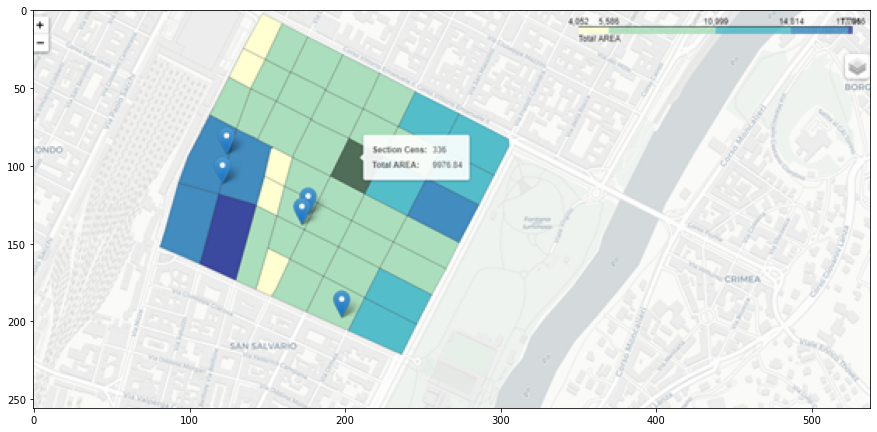

In [ ]:
show_image('https://raw.githubusercontent.com/Bharathi-A-7/WDL/main/i2.png')

# **Population**

In [ ]:
x_map2 = sezioni_geometry.centroid.x.mean()
y_map2 = sezioni_geometry.centroid.y.mean()

m3 = folium.Map(location=[y_map2, x_map2], zoom_start=16,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m3)

scale = (sezioni_censimento['NRESID'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()

m3.choropleth(
 geo_data=sezioni_population,
 name='Choropleth',
 data=sezioni_population,
 columns=['index','NRESID'],
 key_on="feature.properties.index",
 fill_color='PuBuGn',
 threshold_scale=scale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='Population ',
 smooth_factor=0
)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
POP = folium.features.GeoJson(
    sezioni_population,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['SEZCENS','NRESID'],
        aliases=['Section Cens: ',' Population: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m3.add_child(POP)
m3.keep_in_front(POP)
folium.LayerControl().add_to(m3)

for coord in sensor_coords:

  folium.Marker( location=[ coord[0], coord[1]], fill_color = '#43d9de', popup = coord[2],  radius=8).add_to(m3)

m3

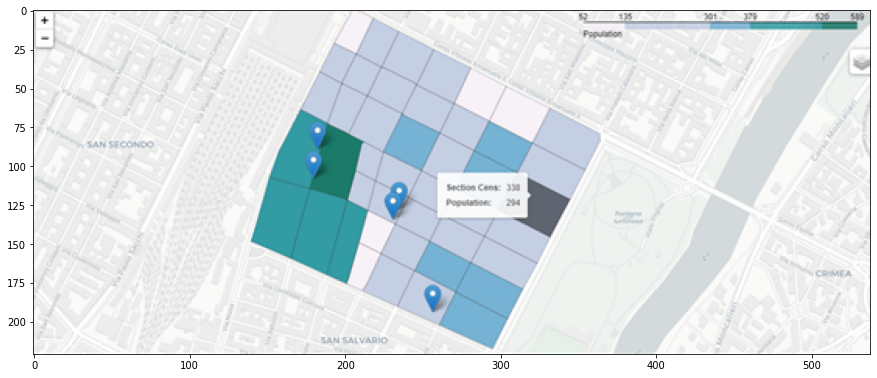

In [ ]:
show_image('https://raw.githubusercontent.com/Bharathi-A-7/WDL/main/i3.png')

# **Population Density**

In [ ]:
m7 = folium.Map(location=[y_map, x_map], zoom_start=16,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m7)

scale = (sezioni_censimento['pop_density'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()

m7.choropleth(
 geo_data=sezioni_popdens,
 name='Choropleth',
 data=sezioni_popdens,
 columns=['index','pop_density'],
 key_on="feature.properties.index",
 fill_color='YlGnBu',
 threshold_scale=scale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='Population Density ',
 smooth_factor=0
)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
popdens = folium.features.GeoJson(
    sezioni_popdens,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['SEZCENS','pop_density'],
        aliases=['Section Cens: ',' Population Density: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m7.add_child(popdens)
m7.keep_in_front(popdens)
folium.LayerControl().add_to(m7)

for coord in sensor_coords:

  folium.Marker( location=[ coord[0], coord[1]], fill_color = '#43d9de', popup = coord[2],  radius=8).add_to(m7)


m7

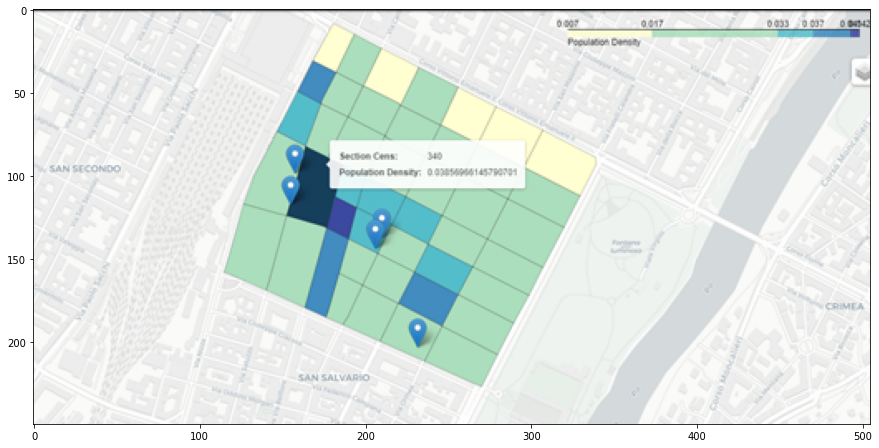

In [ ]:
show_image('https://raw.githubusercontent.com/Bharathi-A-7/WDL/main/i4.png')

If sensors are placed in relatively low population zones, where noise is less likely, they probably are not of much use.

In our opinion, sensors should be placed in residential locations and higher population density to gauge noise levels which could be distrubing for the people.

Placing sensors in commercial places may seem meaningful, but noise in commercial places is mostly inevitable. It is the residential areas that we need to focus on. If noise levels there exceed the limit, we have to take action. And, therefore, it becomes most important to gauge noise at residential places/places close to hospitals

# **Number of Families**

In [ ]:
m4 = folium.Map(location=[y_map2, x_map2], zoom_start=16,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m4)

scale = (sezioni_censimento['NFAMIGL'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()

m4.choropleth(
 geo_data=sezioni_families,
 name='Choropleth',
 data=sezioni_families,
 columns=['index','NFAMIGL'],
 key_on="feature.properties.index",
 fill_color='YlOrBr',
 threshold_scale=scale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='Number of families ',
 smooth_factor=0
)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
FAM = folium.features.GeoJson(
    sezioni_families,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['SEZCENS','NFAMIGL'],
        aliases=['Section Cens: ',' Number of Families: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m4.add_child(FAM)
m4.keep_in_front(FAM)
folium.LayerControl().add_to(m4)

for coord in sensor_coords:

  folium.Marker( location=[ coord[0], coord[1]], fill_color = '#43d9de', popup = coord[2],  radius=8).add_to(m4)

m4

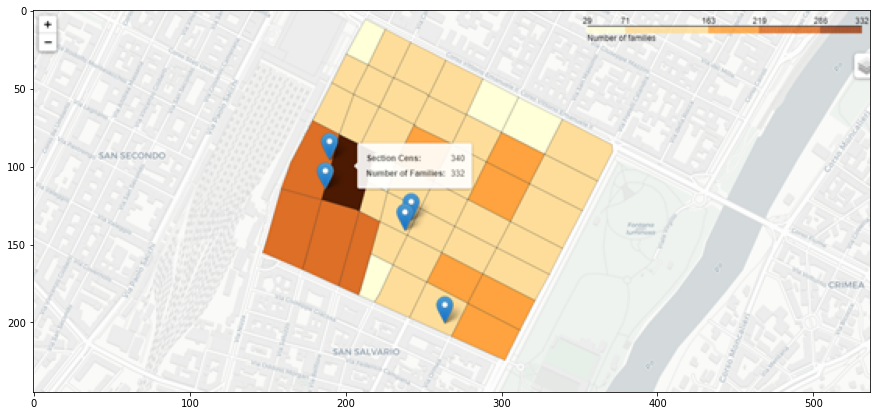

In [ ]:
show_image('https://raw.githubusercontent.com/Bharathi-A-7/WDL/main/i5.png')

Placing sensors in locations where there are very less people / families is not that helpful. We want them to be placed in highly residential areas where noise could not be tolerated and hence must be monitored

# **Sections with 65+ Population**

In [ ]:
m5 = folium.Map(location=[y_map2, x_map2], zoom_start=16,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m5)

scale = (sezioni_censimento['OLT_65_A'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()

m5.choropleth(
 geo_data=sezioni_65plus,
 name='Choropleth',
 data=sezioni_65plus,
 columns=['index','OLT_65_A'],
 key_on="feature.properties.index",
 fill_color='RdPu',
 threshold_scale=scale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='Number of 65+ people ',
 smooth_factor=0
)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
sixty5 = folium.features.GeoJson(
    sezioni_65plus,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['SEZCENS','OLT_65_A'],
        aliases=['Section Cens: ',' Number of 65+: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m5.add_child(sixty5)
m5.keep_in_front(sixty5)
folium.LayerControl().add_to(m5)

for coord in sensor_coords:

  folium.Marker( location=[ coord[0], coord[1]], fill_color = '#43d9de', popup = coord[2],  radius=8).add_to(m5)

m5

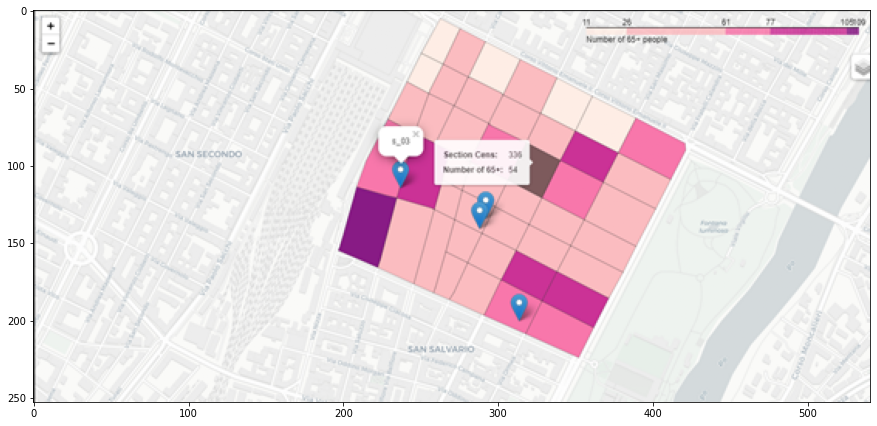

In [ ]:
show_image('https://raw.githubusercontent.com/Bharathi-A-7/WDL/main/i6.png')

# **65+ Age group population density**

In [ ]:
m8 = folium.Map(location=[y_map, x_map], zoom_start=16,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m8)

scale = (sezioni_censimento['s5_density'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()

m8.choropleth(
 geo_data=sezioni_sdens,
 name='Choropleth',
 data=sezioni_sdens,
 columns=['index','s5_density'],
 key_on="feature.properties.index",
 fill_color='BuGn',
 threshold_scale=scale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='65+ Density ',
 smooth_factor=0
)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
sdens = folium.features.GeoJson(
    sezioni_sdens,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['SEZCENS','s5_density'],
        aliases=['Section Cens: ',' 65+ Density: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m8.add_child(sdens)
m8.keep_in_front(sdens)
folium.LayerControl().add_to(m8)

for coord in sensor_coords:

  folium.Marker( location=[ coord[0], coord[1]], fill_color = '#43d9de', popup = coord[2],  radius=8).add_to(m8)


m8

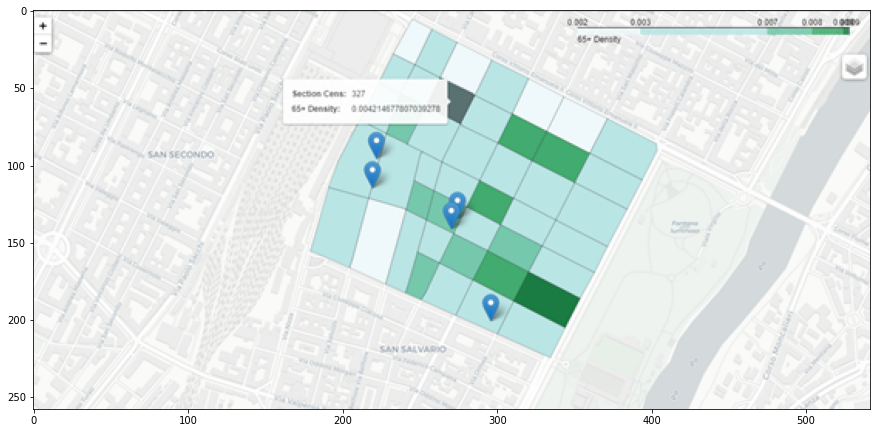

In [ ]:
show_image('https://raw.githubusercontent.com/Bharathi-A-7/WDL/main/i7.png')

Sensors need to placed in locations where there are more number of people in the 65+ age group, to whom noise is distrubing. 

The positioning of sensors need to be re-examined based on these demographic insights

# **Foreigners**

In [ ]:
m6 = folium.Map(location=[y_map2, x_map2], zoom_start=16,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m6)

scale = (sezioni_censimento['NSTRAN'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()

m6.choropleth(
 geo_data=sezioni_foreigners,
 name='Choropleth',
 data=sezioni_foreigners,
 columns=['index','NSTRAN'],
 key_on="feature.properties.index",
 fill_color='GnBu',
 threshold_scale=scale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='Number of foreigners ',
 smooth_factor=0
)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
FOR = folium.features.GeoJson(
    sezioni_foreigners,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['SEZCENS','NSTRAN'],
        aliases=['Section Cens: ',' Number of foreigners: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m6.add_child(FOR)
m5.keep_in_front(FOR)
folium.LayerControl().add_to(m6)

for coord in sensor_coords:

  folium.Marker( location=[ coord[0], coord[1]], fill_color = '#43d9de', popup = coord[2],  radius=8).add_to(m6)

m6

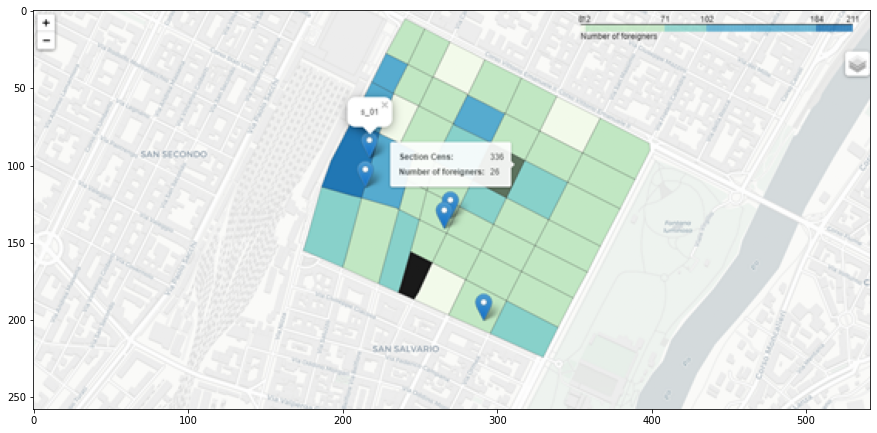

In [ ]:
show_image('https://raw.githubusercontent.com/Bharathi-A-7/WDL/main/i8.png')

The presence of foreigners in tourist areas could lead to more noise. Hence, sensors need to be placed in those locations that house many foreigners

# **Location of Businesses and Sensors**

In [ ]:
san_salvario_business.head(3)

WKT  ... Merchandise Type
0   POINT (1396322.217 4990301.69)  ...   Extralimentari
1   POINT (1396322.217 4990301.69)  ...        Panificio
2  POINT (1396303.762 4990325.001)  ...          Nessuna

[3 rows x 7 columns]

In [ ]:
gs = gpd.GeoSeries.from_wkt(san_salvario_business['WKT'])

In [ ]:
gdf_business = gpd.GeoDataFrame(san_salvario_business, geometry=gs, crs="EPSG:3003")
gdf_business.drop(columns=['WKT'], inplace=True)
gdf_business = gdf_business.to_crs(epsg=4326)
gdf_business['AGE'] = pd.datetime.now().year - gdf_business['OPEN YEAR']

In [ ]:
business_coords = list(zip(gdf_business.geometry.y, gdf_business.geometry.x, gdf_business.AGE))

print(len(business_coords))

business_map = folium.Map(location=[45.055655,7.678555], zoom_start=16, tiles='CartoDB positron')

for sensor_coord  in sensor_coords:

  #Marking sensor location in the mao
  folium.Marker(location=[sensor_coord[0], sensor_coord[1]], popup = sensor_coord[2], color='yellow').add_to(business_map)

  
for business_coord in business_coords:
  
  #Marking business units via circles
  folium.Circle(location=[business_coord[0], business_coord[1]], popup = business_coord[2], color='red', radius=1).add_to(business_map)


business_map


828


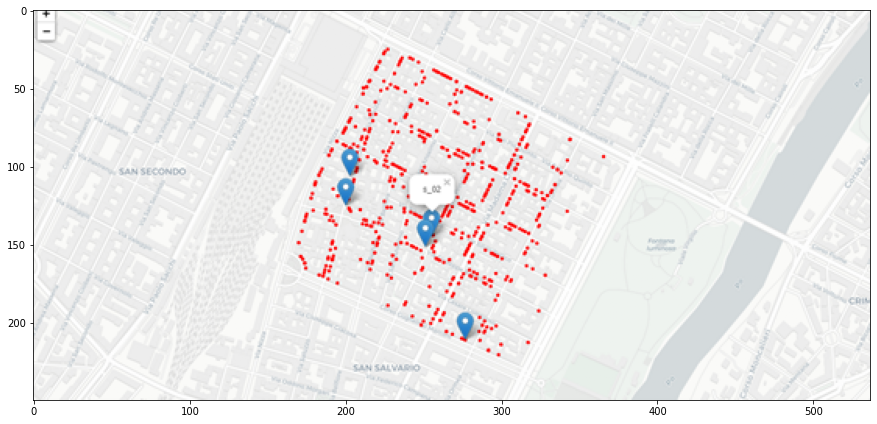

In [ ]:
show_image('https://raw.githubusercontent.com/Bharathi-A-7/WDL/main/i9.png')

Since the sensor S_06(C5) is placed near to multiplane road, there is higher noise level reported, as found from our modeling as well. 

Suggestion : New Businesses should be started away from highway/busy lanes, which are already noisy. Existing businesses should work on reducing noise levels.

# Data processing at level of aggregation - Date and Hour

In [ ]:
data = san_salvario.copy()
sensor_cols = ['C1','C2','C3','C4','C5']

for i in sensor_cols:
    data[i] = data[i].str.replace(',','.')
    data[i] = data[i].astype(float)

# Avg noise level
data['noise_level'] = data[sensor_cols].mean(axis=1)
print(len(data))
print(data.describe())
data.head()

44352
                 C1            C2  ...            C5   noise_level
count  40958.000000  41623.000000  ...  27494.000000  43727.000000
mean      58.265655     56.916284  ...     61.125453     58.495437
std        6.463352      5.953433  ...      4.492895      5.902127
min       28.200000     29.600000  ...     33.100000     29.266667
25%       56.000000     53.800000  ...     58.900000     56.133333
50%       59.900000     58.500000  ...     62.100000     60.200000
75%       62.000000     61.100000  ...     64.100000     62.333333
max       95.600000     80.300000  ...     82.700000     77.000000

[8 rows x 6 columns]


Data    Ora    C1    C2    C3    C4    C5  noise_level
0  01-06-2016  00:00  61.1  58.8  63.7  60.4  60.2        60.84
1  01-06-2016  01:00  57.2  56.1  60.4  57.7  58.4        57.96
2  01-06-2016  02:00  52.5  53.4  52.9  56.7  56.5        54.40
3  01-06-2016  03:00  50.6  46.6  45.7  47.9  55.6        49.28
4  01-06-2016  04:00  47.4  46.2  45.1  45.8  56.8        48.26

In [ ]:
# Make combined datetime column and then convert into date and hour
data['datetime'] = data['Data'] +' ' + data['Ora']
data['datetime'] = pd.to_datetime(data['datetime'])
data['Date'] = pd.to_datetime(data['datetime'].dt.date)
data['Hour'] = data['datetime'].dt.hour
print(len(data))
data.head()

44352


Data    Ora    C1  ...            datetime       Date  Hour
0  01-06-2016  00:00  61.1  ... 2016-01-06 00:00:00 2016-01-06     0
1  01-06-2016  01:00  57.2  ... 2016-01-06 01:00:00 2016-01-06     1
2  01-06-2016  02:00  52.5  ... 2016-01-06 02:00:00 2016-01-06     2
3  01-06-2016  03:00  50.6  ... 2016-01-06 03:00:00 2016-01-06     3
4  01-06-2016  04:00  47.4  ... 2016-01-06 04:00:00 2016-01-06     4

[5 rows x 11 columns]

In [ ]:
# Merge with tto data
# merge with wifi data
# merge with sim data
# merge weather data too
# merge police complaints data

In [ ]:
data = data[['Date','Hour','C1','C2','C3','C4','C5']].merge(tto_data_h[['Date','Hour','tto_mean']], how = 'left', on = ['Date','Hour'])

data = data.merge(wifi_data[['Date','Hour','wifi_visitors']], how = 'left', on = ['Date','Hour'])
data = data.merge(sim_data_pivot, how = 'left', on = ['Date','Hour'])

data = data.merge(weather[['Date','Hour','avg_tempC']], how = 'left', on = ['Date','Hour'])

data = data.merge(police_comp_grp, how = 'left', on = ['Date'])
print(len(data))
data.head()

44352


Date  Hour    C1    C2    C3  ...  Vp  Vr  Vs  avg_tempC  police_complaints
0 2016-01-06     0  61.1  58.8  63.7  ... NaN NaN NaN        NaN                6.0
1 2016-01-06     1  57.2  56.1  60.4  ... NaN NaN NaN        NaN                6.0
2 2016-01-06     2  52.5  53.4  52.9  ... NaN NaN NaN        NaN                6.0
3 2016-01-06     3  50.6  46.6  45.7  ... NaN NaN NaN        NaN                6.0
4 2016-01-06     4  47.4  46.2  45.1  ... NaN NaN NaN        NaN                6.0

[5 rows x 30 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44352 entries, 0 to 44351
Data columns (total 30 columns):
Date                 44352 non-null datetime64[ns]
Hour                 44352 non-null int64
C1                   40958 non-null float64
C2                   41623 non-null float64
C3                   30934 non-null float64
C4                   24793 non-null float64
C5                   27494 non-null float64
tto_mean             20970 non-null float64
wifi_visitors        1639 non-null float64
F1                   816 non-null float64
F2                   816 non-null float64
F3                   816 non-null float64
F4                   816 non-null float64
F5                   816 non-null float64
F6                   816 non-null float64
Gf                   816 non-null float64
Gm                   816 non-null float64
Ni                   816 non-null float64
Ns                   816 non-null float64
P                    816 non-null float64
PH                   816 non-

In [ ]:
# Forecasting
# Multivariate

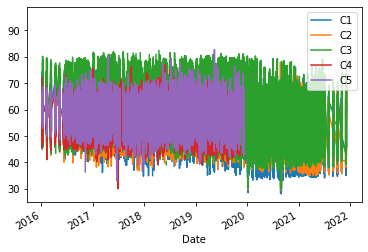

In [ ]:
# Visualization of sensor noise levels, across time
data[['Date','C1','C2','C3','C4','C5']].set_index('Date').plot()

We can see that noise levels vary for each sensor, and have a spectrum

In [ ]:
# Checking avg dB level (noise) for each hour of the day, for each sensor
data.groupby(['Hour'])[sensor_cols].mean().round(1)

C1    C2    C3    C4    C5
Hour                              
0     58.4  56.3  62.5  60.7  59.6
1     55.7  54.0  59.6  58.4  57.4
2     53.0  51.6  56.6  55.9  54.8
3     48.8  48.7  52.0  51.8  53.0
4     47.5  47.5  48.8  49.6  54.3
5     48.5  48.9  49.1  51.0  55.8
6     54.7  52.3  52.9  54.2  58.6
7     62.6  57.9  63.4  59.9  61.8
8     62.4  59.8  62.3  62.5  63.4
9     62.8  59.7  61.9  62.0  63.8
10    61.3  59.7  62.0  61.6  63.9
11    61.4  60.0  61.8  61.6  64.1
12    60.7  59.8  62.1  61.5  63.8
13    60.3  59.4  59.2  61.2  63.7
14    60.1  59.4  59.5  61.0  63.9
15    60.2  59.4  59.3  61.2  64.0
16    60.5  60.4  59.3  61.4  64.2
17    60.8  60.6  59.1  61.6  64.0
18    61.0  60.0  63.6  61.5  63.7
19    60.6  59.7  60.4  61.8  63.5
20    60.0  58.7  58.9  62.0  62.6
21    58.8  57.5  60.1  61.3  60.9
22    58.8  57.2  61.8  61.1  60.5
23    59.4  57.1  63.5  61.4  60.7

We can see that noise levels are low for 1-6 in the morning, but then they increase
And some of the sensors have low variation in noise level throuought the day
but sensor C5 is recording higher noise levels in general and also, higher variation

# So C5 Sensor location to be checked for controlling noise

In [ ]:
# Filter on night hours
data = data[data['Hour'].isin([18,19,20,21,22,23,0,1,2,3])]
print(len(data))
data.head()

18480


Date  Hour    C1    C2    C3  ...  Vp  Vr  Vs  avg_tempC  police_complaints
0  2016-01-06     0  61.1  58.8  63.7  ... NaN NaN NaN        NaN                6.0
1  2016-01-06     1  57.2  56.1  60.4  ... NaN NaN NaN        NaN                6.0
2  2016-01-06     2  52.5  53.4  52.9  ... NaN NaN NaN        NaN                6.0
3  2016-01-06     3  50.6  46.6  45.7  ... NaN NaN NaN        NaN                6.0
18 2016-01-06    18  64.1  63.7   NaN  ... NaN NaN NaN        NaN                6.0

[5 rows x 30 columns]

<AxesSubplot:xlabel='Date'>

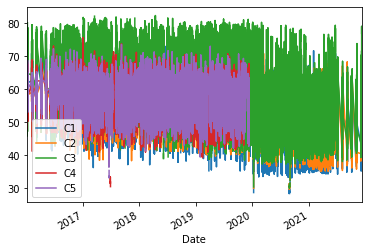

In [ ]:
# Visualization of range (dB) of noise levels across time
data[['Date','C1','C2','C3','C4','C5']].set_index('Date').plot()

In [ ]:
# We want to drop any rows that have Null values in any of these columns
# As these columns are key to our prediction
data = data.dropna(subset = ['wifi_visitors','tto_mean','avg_tempC','police_complaints'])
print(len(data))

266


In [ ]:
data.info()
# The Sim data seems to be for a different time-frame, so we will not be able to directly use them in our forecasting

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 21450 to 22655
Data columns (total 30 columns):
Date                 266 non-null datetime64[ns]
Hour                 266 non-null int64
C1                   266 non-null float64
C2                   266 non-null float64
C3                   266 non-null float64
C4                   266 non-null float64
C5                   266 non-null float64
tto_mean             266 non-null float64
wifi_visitors        266 non-null float64
F1                   0 non-null float64
F2                   0 non-null float64
F3                   0 non-null float64
F4                   0 non-null float64
F5                   0 non-null float64
F6                   0 non-null float64
Gf                   0 non-null float64
Gm                   0 non-null float64
Ni                   0 non-null float64
Ns                   0 non-null float64
P                    0 non-null float64
PH                   0 non-null float64
Tb                   0 non

In [ ]:
# Removing, if any duplicates at Date and Hour level
data2 = data.drop(['Date','Hour'], axis=1)

In [ ]:
# Filtering on selected columns for forecasting
data3 = data2[['C1','C2','C3','C4','C5',
               'tto_mean','wifi_visitors',
              'avg_tempC','police_complaints']]
print(len(data3))
data3.head()

266


C1    C2    C3  ...  wifi_visitors  avg_tempC  police_complaints
21450  62.0  61.2  65.1  ...          197.0        9.5                1.0
21451  60.3  61.6  59.9  ...          223.0        9.5                1.0
21452  59.6  60.3  58.0  ...          203.0        9.5                1.0
21453  57.6  57.5  58.9  ...          180.0        9.5                1.0
21454  58.2  57.9  58.7  ...          191.0        9.5                1.0

[5 rows x 9 columns]

# Time-series decomposition
# Trend, seasonal, noise components

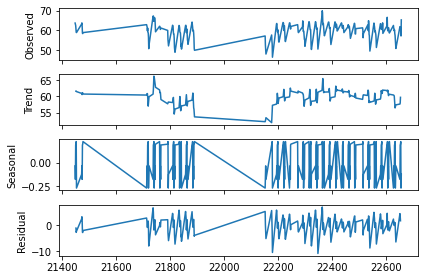

In [ ]:

# Weekly, for one of sensor
res = sm.tsa.seasonal_decompose(data['C5'], freq = 7, model='additive')
res.plot()
plt.show()

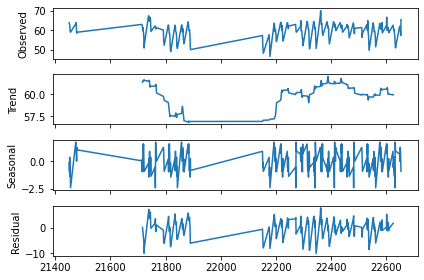

In [ ]:
# Monthly
res = sm.tsa.seasonal_decompose(data['C5'], freq = 28, model='additive')
res.plot()
plt.show()

# Forecasting model

In [ ]:
# Creating the train and validation set
# We are keeping first 90% period as training,
# And rest are validation

# Change this to all columns
#data_f = data[sensor_cols].copy()
data_f = data3.copy()

train = data_f[:int(0.9*(len(data_f)))]
valid = data_f[int(0.9*(len(data_f))):]
print(len(train)), print(len(valid))

239
27


(None, None)

# VAR Model (Vector Auto-regression)
## a model for multivariate time-series forecasting

In [ ]:
# Now, fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# Make prediction on validation
#prediction = model_fit.forecast(model_fit.y, steps=len(valid))

# For next 3 steps
prediction = model_fit.forecast(model_fit.y, steps=3)
len(prediction)

3

In [ ]:
#make final predictions
model = VAR(endog=data_f)
model_fit = model.fit()
prediction = model_fit.forecast(model_fit.y, steps=3)
print(len(prediction))

3


In [ ]:
prediction.shape

(3, 9)

In [ ]:
prediction_df = pd.DataFrame(prediction, columns = data_f.columns)
prediction_df.head()

C1         C2         C3  ...  wifi_visitors  avg_tempC  police_complaints
0  62.067816  60.531192  63.021498  ...     187.049256   7.633699           2.268523
1  60.410215  59.494386  61.368532  ...     193.113866   7.457114           2.448464
2  59.456825  58.646385  60.702580  ...     194.178272   7.303816           2.674818

[3 rows x 9 columns]

## Conclusions

### Scalability and Impact

1. Not having high noise near residential area

2. Banning noise above a dB, after a particular hour in night

3. Relocation of bars/pubs away from a high noise area

4. Mobile concert (to avoide crowding and high noise at a fixed location)

5. Placing sensors at residential/peaceful locations to gauge noise levels, so that people aren't affected. Noises in commercial locations are inevitable.

6. Businesses should be started/located at places far away from highway/busy lanes

Now that we are able to build prediction for 3 hours ahead for our sensors
We can utilize them for ad-hoc noise control measures, to avoid police complaints

We note that C5, and C3 have higher noise predictions, so they need more sustaoned measures to control noise


### Future Work


1. Getting access to data about Bars, Clubs, sports events, concerts etc.

2. Data Across Timeframes.

3. Getting more features for our multivariate time series problem. 
